# Use examples of [edges](https://github.com/romainsacchi/edges)

Author: [romainsacchi](https://github.com/romainsacchi)

This notebook shows examples on how to use `edge` to use exchange-specific
characterization factors in the characterization matrix of `bw2calc`.

## Requirements

* **Pyhton 3.10 or higher (up to 3.11) is highly recommended**

# Use case with [brightway2](https://brightway.dev/)

`brightway2` is an open source LCA framework for Python.
To use `premise` from `brightway2`, it requires that you have an activated `brightway2` project with a `biosphere3` database as well as an [ecoinvent](https://ecoinvent.prg) v.3 cut-off or consequential database registered in that project. Please refer to the brightway [documentation](https://brightway.dev) if you do not know how to create a project and install ecoinvent.

## Example 1: simple biosphere-technosphere LCIA

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

One can simply build its own LCIA file.
Let's consider the following LCIA file (saved under `lcia_example_1.json`):

In [2]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for greenhouse gas emissions",
    "unit": "kg CO2e",
    "strategies": [
        "map_exchanges"
    ],
  "exchanges": [
    {
      "supplier": {
        "name": "Carbon dioxide",
        "operator": "startswith",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 1.0
    },
    {
      "supplier": {
        "name": "Methane, fossil",
        "operator": "contains",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 28.0
    },
    {
      "supplier": {
        "name": "Dinitrogen monoxide",
        "operator": "equals",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": 265.0
    }
  ]
}

In [4]:
# activate the bw project
#bw2data.projects.set_current("ecoinvent-3.11-cutoff")
bw2data.projects.set_current("bw25_ei310")
#act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
act

'market for brick production facility' (unit, GLO, None)

In [5]:
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

No handlers could be found for logger "edges.edgelcia.EdgeLCIA"
Mapping exchanges: 100%|██████████| 3/3 [00:00<00:00, 80.28it/s]


13552804.714796193

We can print some statistics:

In [6]:
LCA.statistics()

+----------------------+--------------------------------------+
|       Activity       | market for brick production facility |
|     Method name      |         Example LCIA Method          |
|         Unit         |               kg CO2e                |
|      Data file       |                                      |
|    CFs in method     |                  3                   |
|       CFs used       |                  3                   |
|   Unique CFs used    |                  3                   |
|  Exc. characterized  |                12788                 |
| Exc. uncharacterized |                323120                |
+----------------------+--------------------------------------+


### Generate dataframe of characterization factors used

The `generate_cf_table` method generates a dataframe of the characterization factors used in the calculation. One can see the characterization factors used for each exchange in the system.

In [7]:
df = LCA.generate_cf_table(include_unmatched=False)

In [8]:
# we can see under the "CF" column
# the characterization factors used for each exchange in the system
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,"Carbon dioxide, fossil","(air, urban air close to ground)","treatment of rainwater mineral oil storage, wa...",rainwater mineral oil storage,RoW,0.202864,1.0,0.202864
1,"Carbon dioxide, fossil","(air, urban air close to ground)","treatment of rainwater mineral oil storage, wa...",rainwater mineral oil storage,RoW,0.202864,1.0,0.202864
2,"Carbon dioxide, fossil","(air, urban air close to ground)",atrazine production,atrazine,RoW,0.006092,1.0,0.006092
3,"Carbon dioxide, fossil","(air, urban air close to ground)",atrazine production,atrazine,RoW,0.006092,1.0,0.006092
4,"Carbon dioxide, fossil","(air, urban air close to ground)","sulfate pulp production, from softwood, bleached","tall oil, crude",RER,0.002476,1.0,0.002476
...,...,...,...,...,...,...,...,...
25571,Dinitrogen monoxide,"(air,)","market for electricity, high voltage","electricity, high voltage",NE,0.001150,265.0,0.304759
25572,Dinitrogen monoxide,"(air,)","fibreboard production, hard","residual wood, dry",RoW,0.000015,265.0,0.004093
25573,Dinitrogen monoxide,"(air,)","fibreboard production, hard","residual wood, dry",RoW,0.000015,265.0,0.004093
25574,Dinitrogen monoxide,"(air,)","market for electricity, high voltage","electricity, high voltage",IN-Eastern grid,0.286725,265.0,75.982252


In [9]:
df.groupby("supplier name")["CF"].mean()

supplier name
Carbon dioxide, fossil                               1.0
Carbon dioxide, from soil or biomass stock           1.0
Carbon dioxide, in air                               1.0
Carbon dioxide, non-fossil                           1.0
Carbon dioxide, non-fossil, resource correction      1.0
Carbon dioxide, to soil or biomass stock             1.0
Dinitrogen monoxide                                265.0
Methane, fossil                                     28.0
Name: CF, dtype: float64

## Example 2: biosphere-technosphere LCIA with parameters and scenarios

In this example, the evaluation of the CFs for `methane` and `dinitrogen monoxide` is a **symbolic expression depending on the value of the parameter `co2ppm`**. It is a simple approximation of the GWP100 factor of these gases as a function of the atmospheric CO₂ concentration.

In [10]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for greenhouse gas emissions",
    "unit": "kg CO2e",
    "exchanges": [
      {
        "supplier": {
          "name": "Carbon dioxide",
          "operator": "startswith",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "1.0"
      },
      {
        "supplier": {
          "name": "Methane, fossil",
          "operator": "contains",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "28 * (1 + 0.001 * (co2ppm - 410))"
      },
      {
        "supplier": {
          "name": "Dinitrogen monoxide",
          "operator": "equals",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "265 * (1 + 0.0005 * (co2ppm - 410))"
      }
  ]
}

In [14]:
import bw2data
from edges import EdgeLCIA

# Select an activity from the LCA database
#bw2data.projects.set_current("ecoinvent-3.11-cutoff")
bw2data.projects.set_current("bw25_ei310")
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
print(act)

# Define scenario parameters (e.g., atmospheric CO₂ concentration and time horizon)
params = {
    "some scenario": {
         "co2ppm": {
             "2020": 410,
             "2050": 450,
             "2100": 500},
        "h": {
            "2020": 100,
            "2050": 100,
            "2100": 100
        }
    }
}

# Initialize LCIA
lcia = EdgeLCIA(
   demand={act: 1},
   method=method,
   parameters=params
)

# Perform inventory calculations (once)
lcia.lci()

# Map exchanges to CF entries (once)
lcia.map_exchanges()


# Run scenarios efficiently
results = []
for idx in {"2020", "2050", "2100"}:
    lcia.evaluate_cfs(idx)
    lcia.lcia()
    #df = lcia.generate_cf_table()

    #scenario_result = {
    #    "scenario": idx,
    #    "co2ppm": params["some scenario"]["co2ppm"][idx],
    #    "score": lcia.score,
    #    "CF_table": df
    #}
    #results.append(scenario_result)

    print(f"Scenario (CO₂ {params['some scenario']['co2ppm'][idx]} ppm): Impact = {lcia.score}")

'uranium production, centrifuge, enriched 3.9%' (unit, RU, None)


Mapping exchanges: 100%|██████████| 3/3 [00:00<00:00, 98.68it/s]

Scenario (CO₂ 450 ppm): Impact = 296.47332014667006
Scenario (CO₂ 410 ppm): Impact = 295.39898916902933
Scenario (CO₂ 500 ppm): Impact = 297.81623386872093


## Example 3: biosphere-technosphere LCIA with function call

In this example, the evaluation of the CFs for `methane` and `dinitrogen monoxide` is returned by a call to an external function `GWP`.

We first create a function that will claculate the GWP of a given over a given tine horizon.
Inspired from the IPCC AR5, 2021.

In [15]:
import numpy as np
# Physical constants
M_atm = 5.15e18  # kg, total mass of Earth's atmosphere
M_air = 28.96    # g/mol, average molar mass of air

# Gas-specific molecular weights (g/mol)
M_gas = {
    'CO2': 44.01,
    'CH4': 16.04,
    'N2O': 44.013
}

# IPCC concentration parameters (Myhre et al. 1998 / IPCC AR6)
RF_COEFF = {
    'CH4': 0.036,  # W·m⁻²·ppb⁻½ for CH4
    'N2O': 0.12    # W·m⁻²·ppb⁻½ for N2O
}

# Reference atmospheric concentrations (IPCC AR6, ~2019)
C_REF = {
    'CH4': 1866,  # ppb
    'N2O': 332    # ppb
}

# Indirect forcing factor for methane (IPCC AR6)
INDIRECT_FACTOR = {
    'CH4': 1.65,
    'N2O': 1.0
}

# Gas-specific atmospheric lifetimes (years, IPCC AR6)
TAU_GAS = {
    'CH4': 11.8,
    'N2O': 109
}

# CO2 impulse response function parameters (IPCC AR5/AR6)
CO2_IRF = {
    'a0': 0.2173,
    'a': [0.2240, 0.2824, 0.2763],
    'tau': [394.4, 36.54, 4.304]
}

# Convert concentration-based radiative efficiency to mass-based (W·m⁻²·kg⁻¹)
def convert_ppb_to_mass_rf(a_ppb, gas):
    return a_ppb * (M_atm / M_gas[gas]) * (M_air / 1e9)

# Calculate concentration-dependent radiative efficiency
def radiative_efficiency_concentration(gas, concentration_ppb):
    alpha = RF_COEFF[gas]
    return (alpha / (2 * np.sqrt(concentration_ppb))) * INDIRECT_FACTOR[gas]

# AGWP for CO2 (mass-based)
def AGWP_CO2(H):
    integral_CO2 = CO2_IRF['a0'] * H + sum(
        a * tau * (1 - np.exp(-H / tau))
        for a, tau in zip(CO2_IRF['a'], CO2_IRF['tau'])
    )
    am_CO2 = convert_ppb_to_mass_rf(1.37e-5, 'CO2')  # fixed IPCC radiative efficiency for CO2
    return am_CO2 * integral_CO2

# AGWP for gas at given concentration
def AGWP_gas(gas, H, concentration_ppb):
    aa_gas = radiative_efficiency_concentration(gas, concentration_ppb)
    am_gas = convert_ppb_to_mass_rf(aa_gas, gas)
    tau_gas = TAU_GAS[gas]
    return am_gas * tau_gas * (1 - np.exp(-H / tau_gas))

# Calculate concentration-dependent GWP
def GWP(gas, H, concentration_ppb):
    AGWP_g = AGWP_gas(gas, H, concentration_ppb)
    AGWP_ref = AGWP_CO2(H)
    return AGWP_g / AGWP_ref


In [16]:
GWP('CH4', 100, 1911)

30.660731597024444

In [17]:
method = {
  "name": [
    "Parameterized GWP method"
  ],
  "unit": "kg CO2-eq",
  "description": "Parameterized GWP factors.",
  "version": "1.0",
  "exchanges": [
    {
      "supplier": {
        "name": "Carbon dioxide",
        "operator": "startswith",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": "1.0"
    },
    {
        "supplier": {
          "name": "Methane, fossil",
          "operator": "contains",
          "matrix": "biosphere"
        },
        "consumer": {
          "matrix": "technosphere",
        },
        "value": "GWP('CH4',H, C_CH4)"
      },
    {
      "supplier": {
        "name": "Dinitrogen monoxide",
        "operator": "equals",
        "matrix": "biosphere"
      },
      "consumer": {
        "matrix": "technosphere",
      },
      "value": "GWP('N2O',H, C_N2O)"
    }
  ],
  "scenarios": {
    "RCP1.9": {
      "C_CH4": {
        "2020": 1866,
        "2050": 1428,
        "2080": 1150,
        "2100": 1036
      },
      "C_N2O": {
        "2020": 332,
        "2050": 344,
        "2080": 350,
        "2100": 354
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP2.6": {
      "C_CH4": {
        "2020": 1866,
        "2050": 1519,
        "2080": 1197,
        "2100": 1056
      },
      "C_N2O": {
        "2020": 332,
        "2050": 344,
        "2080": 349,
        "2100": 354
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP4.5": {
      "C_CH4": {
        "2020": 1866,
        "2050": 2020,
        "2080": 1779,
        "2100": 1683
      },
      "C_N2O": {
        "2020": 332,
        "2050": 356,
        "2080": 373,
        "2100": 377
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    },
    "RCP8.5": {
      "C_CH4": {
        "2020": 1866,
        "2050": 2446,
        "2080": 2652,
        "2100": 2415
      },
      "C_N2O": {
        "2020": 332,
        "2050": 358,
        "2080": 380,
        "2100": 392
      },
      "H": {
        "2020": 100,
        "2050": 100,
        "2080": 100,
        "2100": 100
      }
    }
  }
}



In [18]:
# we declare the function
allowed_funcs = {"GWP": GWP}

In [19]:
all_results = []  # To collect results

# Initialize LCIA
lcia = EdgeLCIA(
    demand={act: 1},
    method=method,
    allowed_functions=allowed_funcs # we declare the functions to call.
)

# Usual LCIA steps
lcia.lci()
lcia.map_exchanges()

results = []
# Loop over scenarios
for scenario in [
    "RCP1.9",
    "RCP2.6",
    "RCP4.5",
    "RCP8.5",
]:
    for year in [
        "2020",
        "2050",
        "2080",
        "2100",
    ]:
        print(scenario, year)
        lcia.evaluate_cfs(scenario=scenario, scenario_idx=year)
        lcia.lcia()
        # df = lcia.generate_cf_table()

        #scenario_result = {
        #    "year": int(year),
        #    "rcp": scenario,
        #    "score": lcia.score,
        #    "CF_table": df
        #}
        #all_results.append(scenario_result)

        print(f"Year {year} | {scenario}: Impact = {lcia.score}")

Mapping exchanges: 100%|██████████| 3/3 [00:00<00:00, 96.25it/s]


RCP1.9 2020
Year 2020 | RCP1.9: Impact = 298.70396960797945
RCP1.9 2050
Year 2050 | RCP1.9: Impact = 302.46533161864426
RCP1.9 2080
Year 2080 | RCP1.9: Impact = 305.94353898406877
RCP1.9 2100
Year 2100 | RCP1.9: Impact = 307.75374540313845
RCP2.6 2020
Year 2020 | RCP2.6: Impact = 298.70396960797945
RCP2.6 2050
Year 2050 | RCP2.6: Impact = 301.52720588119155
RCP2.6 2080
Year 2080 | RCP2.6: Impact = 305.26997289859196
RCP2.6 2100
Year 2100 | RCP2.6: Impact = 307.40920257308176
RCP4.5 2020
Year 2020 | RCP4.5: Impact = 298.70396960797945
RCP4.5 2050
Year 2050 | RCP4.5: Impact = 297.4598632052442
RCP4.5 2080
Year 2080 | RCP4.5: Impact = 299.03387106186506
RCP4.5 2100
Year 2100 | RCP4.5: Impact = 299.78248181338375
RCP8.5 2020
Year 2020 | RCP8.5: Impact = 298.70396960797945
RCP8.5 2050
Year 2050 | RCP8.5: Impact = 295.0783327124703
RCP8.5 2080
Year 2080 | RCP8.5: Impact = 293.9835055399346
RCP8.5 2100
Year 2100 | RCP8.5: Impact = 294.9859752328024


## Example 5: biosphere-technosphere LCIA with geographies and uncertainty

In this example, we try to characterize water withdrawals, and uncertainty information.

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

In [2]:
method = {
  "name": "Example LCIA Method",
    "version": "1.0",
    "description": "Example LCIA method for water withdrawals",
    "unit": "m3 freshwater",
    "strategies": [
        "map_exchanges",
        "map_contained_locations"
    ],
  "exchanges": [
    {
         "supplier": {
            "name": "Water",
            "matrix": "biosphere"
         },
         "consumer": {
            "location": "RER",
            "matrix": "technosphere",
         },
         "value": 17,
         "weight": 213938000,
         "uncertainty": {
            "distribution": "discrete_empirical",
            "parameters": {
               "values": [
                  6.87,
                  7.56,
                  13.4,
                  15.5,
                  18.7,
                  19.1,
                  21.5,
                  21.8,
                  27.6,
                  29.8,
                  31.0,
                  33.5,
                  33.7,
                  34.6
               ],
               "weights": [
                  0.153,
                  0.324,
                  0.015,
                  0.038,
                  0.079,
                  0.008,
                  0.0,
                  0.075,
                  0.074,
                  0.0,
                  0.008,
                  0.013,
                  0.08,
                  0.131
               ]
            }
         }
      },
      {
         "supplier": {
            "name": "Water",
            "matrix": "biosphere"
         },
         "consumer": {
            "location": "FR",
            "matrix": "technosphere",
            "classifications": {
               "CPC": [
                  "01"
               ]
            }
         },
         "value": 10,
         "weight": 213938000,
         "uncertainty": {
            "distribution": "triang",
            "parameters": {
               "loc": 11,
               "minimum": 0.752,
               "maximum": 50.6
            }
         }
      }
  ]
}

In [7]:
# bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
bw2data.projects.set_current("bw25_ei310")
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
act

'transport, pipeline, onshore, long distance, natural gas' (ton kilometer, GB, None)

In [9]:
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

Processing contained groups (pass 1): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


0.2126286872013535

In [10]:
df = LCA.generate_cf_table()

In [11]:
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
0,Water,"(water, ocean)","chlor-alkali electrolysis, average production",potassium hydroxide,RER,1.407993e-12,17.0,2.393588e-11
1,Water,"(water, ocean)","chlor-alkali electrolysis, average production","sodium hypochlorite, without water, in 15% sol...",RER,1.868897e-07,17.0,3.177124e-06
2,Water,"(water, ocean)",liquid packaging board production,bark,RER,2.196598e-14,17.0,3.734217e-13
3,Water,"(water, ocean)","chlor-alkali electrolysis, average production","hydrogen, gaseous, low pressure",RER,3.946874e-13,17.0,6.709685e-12
4,Water,"(water, ocean)","sodium perborate production, tetrahydrate, powder","sodium perborate, tetrahydrate, powder",RER,2.201561e-14,17.0,3.742654e-13
...,...,...,...,...,...,...,...,...
3061,Water,"(air,)",hard coal mine operation and hard coal prepara...,hard coal,"Europe, without Russia and Türkiye",2.990866e-09,17.0,5.084473e-08
3062,Water,"(water,)",hard coal mine operation and hard coal prepara...,hard coal,"Europe, without Russia and Türkiye",1.694824e-08,17.0,2.881201e-07
3063,Water,"(water, surface water)","nitric acid production, product in 50% solutio...","nitric acid, without water, in 50% solution state",RER w/o RU,8.822756e-10,17.0,1.499869e-08
3064,Water,"(air,)","ammonia production, steam reforming, liquid","ammonia, anhydrous, liquid",RER w/o RU,9.374950e-09,17.0,1.593741e-07


In [12]:
df.groupby("consumer location")["CF"].unique()

consumer location
AT                                              [17.0]
BA                                              [17.0]
BE                                              [17.0]
BG                                              [17.0]
CH                                              [17.0]
CZ                                              [17.0]
DE                                              [17.0]
DK                                              [17.0]
EE                                              [17.0]
ES                                              [17.0]
Europe without Austria                          [17.0]
Europe without Switzerland                      [17.0]
Europe without Switzerland and Austria          [17.0]
Europe, without Russia and Türkiye              [17.0]
FI                                              [17.0]
FR                                        [10.0, 17.0]
GB                                              [17.0]
GR                                             

In [14]:
df.loc[
    (df["consumer location"] == "FR")
]

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF,impact
1094,Water,"(air,)",barley grain production,barley grain,FR,2.954310e-16,10.0,2.954310e-15
1095,Water,"(air,)",rape seed production,rape seed,FR,2.432410e-13,10.0,2.432410e-12
1096,Water,"(air,)",wheat grain production,wheat grain,FR,5.335113e-15,10.0,5.335113e-14
1097,Water,"(water, ground-)",sugar beet production,sugar beet,FR,1.021154e-17,10.0,1.021154e-16
1098,Water,"(water, ground-)",barley grain production,barley grain,FR,6.113135e-17,10.0,6.113135e-16
...,...,...,...,...,...,...,...,...
2721,Water,"(water,)","heat and power co-generation, natural gas, con...","electricity, high voltage",FR,5.879525e-08,17.0,9.995193e-07
2722,Water,"(air,)","electricity production, photovoltaic, 3kWp sla...","electricity, low voltage",FR,8.072278e-15,17.0,1.372287e-13
2723,Water,"(water,)","treatment of used vegetable cooking oil, purif...",fatty acid methyl ester,FR,1.469808e-16,17.0,2.498673e-15
2724,Water,"(air,)","electricity production, natural gas, combined ...","electricity, high voltage",FR,1.185513e-09,17.0,2.015372e-08


In [ ]:
act = [x for x in bw2data.Database("ecoinvent-3.10.1-cutoff") if x['location']=='FR' and "electricity production, hydro" in x["name"]][0]
print(act)
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
    use_distributions=True,
    iterations=10_000
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

'electricity production, hydro, run-of-river' (kilowatt hour, FR, None)


No handlers could be found for logger "edges.edgelcia.EdgeLCIA"
Processing contained groups (pass 1): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1068f2ed0>>
Traceback (most recent call last):
  File "/Users/romain/micromamba/envs/edges/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [5]:
type(LCA.score.data)

numpy.ndarray

(array([1541., 3237.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  157.,    0.,    0.,    0.,  383.,    0.,    0.,
           0.,    0.,    0.,  791.,   85.,    0.,    0.,    0.,  766.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  718.,    0.,    0.,    0.,    0.,    0.,   64.,    0.,
           0.,    0.,    0.,  967., 1291.]),
 array([ 60.07230585,  64.92181107,  69.77131628,  74.6208215 ,
         79.47032671,  84.31983193,  89.16933714,  94.01884236,
         98.86834757, 103.71785279, 108.567358  , 113.41686322,
        118.26636843, 123.11587365, 127.96537886, 132.81488408,
        137.66438929, 142.51389451, 147.36339972, 152.21290494,
        157.06241015, 161.91191537, 166.76142058, 171.6109258 ,
        176.46043101, 181.30993623, 186.15944144, 191.00894666,
        195.85845187, 200.70795709, 205.5574623 , 210.40696752,
        215.25647273, 220.10597795, 224.95548316, 229.80498838,
        234.65449359, 23

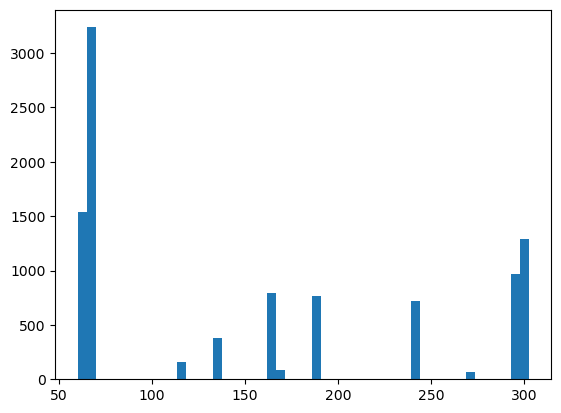

In [6]:
import matplotlib.pyplot as plt
plt.hist(LCA.score.data, bins=50)

In [7]:
df = LCA.generate_cf_table()

In [8]:
df

,supplier name,supplier categories,consumer name,consumer reference product,consumer location,amount,CF (mean),CF (std),CF (min),CF (5th),...,CF (max),impact (mean),impact (std),impact (min),impact (5th),impact (25th),impact (50th),impact (75th),impact (95th),impact (max)
0,Water,"(water, ocean)","evaporation of natural gas, import from TT","natural gas, high pressure",GB,6.226422e-06,17.523819,11.085148,6.87,6.87,...,34.6,1.091107e-04,6.902081e-05,4.277552e-05,4.277552e-05,4.707175e-05,9.650955e-05,1.718493e-04,2.154342e-04,2.154342e-04
1,Water,"(water, ocean)","evaporation of natural gas, import from NG","natural gas, high pressure",GB,3.291510e-06,17.523819,11.085148,6.87,6.87,...,34.6,5.767983e-05,3.648688e-05,2.261268e-05,2.261268e-05,2.488382e-05,5.101841e-05,9.084569e-05,1.138863e-04,1.138863e-04
2,Water,"(water, ocean)","chlor-alkali electrolysis, average production",potassium hydroxide,RER,5.023847e-11,17.523819,11.085148,6.87,6.87,...,34.6,8.803698e-10,5.569008e-10,3.451383e-10,3.451383e-10,3.798028e-10,7.786962e-10,1.386582e-09,1.738251e-09,1.738251e-09
3,Water,"(water, ocean)","evaporation of natural gas, import from US","natural gas, high pressure",ES,1.131347e-03,17.523819,11.085148,6.87,6.87,...,34.6,1.982552e-02,1.254115e-02,7.772355e-03,7.772355e-03,8.552984e-03,1.753588e-02,3.122518e-02,3.914461e-02,3.914461e-02
4,Water,"(water, ocean)","evaporation of natural gas, import from DZ","natural gas, high pressure",BE,2.372190e-05,17.523819,11.085148,6.87,6.87,...,34.6,4.156983e-04,2.629608e-04,1.629695e-04,1.629695e-04,1.793376e-04,3.676894e-04,6.547244e-04,8.207777e-04,8.207777e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,Water,"(water, surface water)","soybean production, organic","soybean, organic",CH,7.663051e-31,17.523819,11.085148,6.87,6.87,...,34.6,1.342859e-29,8.494605e-30,5.264516e-30,5.264516e-30,5.793266e-30,1.187773e-29,2.115002e-29,2.651416e-29,2.651416e-29
3062,Water,"(water, surface water)","treatment of sewage sludge, 70% water, WWT, WW...","sewage sludge, 70% water, WWT, WW from PV cell...",CH,3.212398e-15,17.523819,11.085148,6.87,6.87,...,34.6,5.629347e-14,3.560990e-14,2.206917e-14,2.206917e-14,2.428573e-14,4.979216e-14,8.866217e-14,1.111490e-13,1.111490e-13
3063,Water,"(water, surface water)","treatment of waste expanded polystyrene, munic...",waste expanded polystyrene,CH,6.006625e-11,17.523819,11.085148,6.87,6.87,...,34.6,1.052590e-09,6.658432e-10,4.126551e-10,4.126551e-10,4.541008e-10,9.310268e-10,1.657828e-09,2.078292e-09,2.078292e-09
3064,Water,"(water, surface water)","treatment of leachate, SLF, residue from cooli...","leachate, SLF, residue from cooling tower",CH,5.220876e-12,17.523819,11.085148,6.87,6.87,...,34.6,9.148968e-11,5.787418e-11,3.586742e-11,3.586742e-11,3.946982e-11,8.092357e-11,1.440962e-10,1.806423e-10,1.806423e-10


### Bonus: Sankey diagram

In [12]:
from edges import SupplyChain

In [15]:
sc = SupplyChain(
    activity=act,
    method=method,
    amount=1,
    level=8,
    cutoff=0.01,
    cutoff_basis="total",
    collapse_markets=False,
)
total = sc.bootstrap()
df, total_score, ref_amount = sc.calculate()

sc.save_html(
    df,
    path="example_sankey.html",
    height_max=1000,
    width_max=2400,
    node_instance_mode="by_parent",  # or "by_child_level" / "by_level"
    node_thickness=12
)

Processing contained groups (pass 1): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


'example_sankey.html'

## Example 6: technosphere-technosphere LCIA

In this example, we want to characterize intermediate product exchanges.
Here, we are interested in the amount of **secondary copper** flowing in the system.

In [51]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import bw2data

In [52]:
method = {
  "name": "ecoinvent 3.10/3.11 - RELICS - Copper, secondary",
  "unit": "kg",
  "version": "1.0",
  "strategies": [
       "map_exchanges"
   ],
  "exchanges": [
    {
      "supplier": {
        "name": "treatment of",
        "reference product": "copper, cathode",
        "operator": "startswith",
        "matrix": "technosphere",
        "excludes": [
          "market"
        ]
      },
      "consumer": {
        "matrix": "technosphere"
      },
      "value": 1.0
    },
    {
        "supplier": {
          "name": "treatment of",
          "reference product": "copper, anode",
          "operator": "startswith",
          "matrix": "technosphere",
          "excludes": [
            "market",
            "slime"
          ]
        },
        "consumer": {
          "matrix": "technosphere"
        },
        "value": 1.0
      }
  ]
}

In [53]:
bw2data.projects.set_current("ecoinvent-3.11-cutoff-bw25")
act = bw2data.Database("ecoinvent-3.11-cutoff").random()
act

'market for sugarcane' (kilogram, RoW, None)

In [55]:
LCA = EdgeLCIA(
    demand={act: 1000},
    method=method,
)
LCA.lci()

LCA.apply_strategies()
#LCA.map_exchanges()

LCA.evaluate_cfs()
LCA.lcia()
LCA.score

Mapping exchanges: 100%|█████████████████████████| 2/2 [00:00<00:00, 105.54it/s]


0.004364476233005034

In [56]:
df = LCA.generate_cf_table()

In [57]:
df

,supplier name,supplier reference product,supplier location,consumer name,consumer reference product,consumer location,amount,CF,impact
0,treatment of copper scrap by electrolytic refi...,"copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,3.291248e-03,1.0,3.291248e-03
1,treatment of copper scrap by electrolytic refi...,"copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,3.291248e-03,1.0,3.291248e-03
2,treatment of copper cake,"copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,4.817732e-05,1.0,4.817732e-05
3,treatment of copper cake,"copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,4.817732e-05,1.0,4.817732e-05
4,"treatment of non-Fe-Co-metals, from used Li-io...","copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,2.042373e-08,1.0,2.042373e-08
5,"treatment of non-Fe-Co-metals, from used Li-io...","copper, cathode",GLO,"market for copper, cathode","copper, cathode",GLO,2.042373e-08,1.0,2.042373e-08
6,treatment of copper scrap by electrolytic refi...,"copper, cathode",RER,"market for copper, cathode","copper, cathode",GLO,7.454642e-04,1.0,7.454642e-04
7,treatment of copper scrap by electrolytic refi...,"copper, cathode",RER,"market for copper, cathode","copper, cathode",GLO,7.454642e-04,1.0,7.454642e-04
8,"treatment of metal part of electronics scrap, ...","copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,1.840048e-05,1.0,1.840048e-05
9,"treatment of metal part of electronics scrap, ...","copper, cathode",RoW,"market for copper, cathode","copper, cathode",GLO,1.840048e-05,1.0,1.840048e-05
